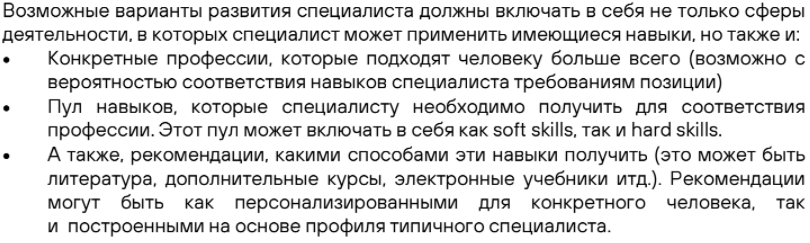

Идеи:
* Складывать косинусную схожесть у одинаковых профессий, нормировать для совета в какую профессию пойти(выписано)
* Приделать фильтр по городу и опыту(выписано)
* Сделать таблицу по csr_rates как в ворде, добавить веса пропорционалные мере схожести.


In [1]:
!pip install pymorphy2

     |████████████████████████████████| 61kB 3.0MB/s 
     |████████████████████████████████| 8.2MB 6.2MB/s 


## 1 Импорт необходимых библиотек

In [166]:
import requests 
import re
import nltk
import time
from IPython.display import clear_output

from functools import reduce
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import gensim
import pymorphy2

## 2 Классы для получения и обработки данных, создания рекомендаций

### 2.1 Для получения данных с сайта hh.ru

In [167]:
class ParseData():
    def __init__(self, api, params=None,  pages=10):
        self.__api = api
        self.__params = params
        self._pages = pages
        self.data = self._get_request()
        self.df = self._get_data()
    

    # получение данных в формат json
    def _get_request(self):
        data = []
        for item in ['Аналитик', 'Разработчик', 'Data Scientist', 'Маркетинг', 'Дизайн IT']:
            for i in range(self._pages):
                page = self.__params
                page['page'] = i
                page['text'] = 'NAME:' + item
                try:
                    response = requests.get(self.__api, page).json()
                    if len(response['items']) != 0:
                        data.extend(response['items'])
                    else:
                        print('Вакансий больше нет')
                        break
                except: 
                    print('Результат не интерпретируется в формате json')
        return data


    # получение таблицы по вакансиям из данных полученных в _get_request
    def _get_data(self, timeout = 0.5, retries = 5):

        # таким будет список признаков
        dict_for_resps = {'name': [], 'key_skills': [], 'salary': [], 
                         'specializations': [] , 'description': [], 
                          'experience': []}

        # проходимся в цикле по всем объектам данных формата json(self.data)
        for i, item in enumerate(self.data):
            retry = 0
            # цикл с try для исключения ошибок при парсинге
            while retry < retries:
                try:
                    response = requests.get(item['url'])
                    resp_json = response.json()
                
                    # добавляем строку данных в таблицу с указанными выше признаками
                    for feat in dict_for_resps.keys():
                        dict_for_resps[feat].append(resp_json[feat]) 

                    clear_output(wait=True)
                    print(f'Успешно {i+1}')
                    break
                except:
                    print(f'Таймаут на {timeout}. Код ошибки {response.status_code}')
                    time.sleep(timeout)
                    retry += 1
        return pd.DataFrame(dict_for_resps)    

  

### 2.2 Класс для обработки данных и для подбора рекомендаций

In [170]:
class RecSystem(ParseData):

    # здесь определен лемматизатор вместе с паттерном
    def __init__(self, api, params=None,  pages=10):
        super().__init__(api, params,  pages)
        self.lemmatizer = pymorphy2.MorphAnalyzer()
        self.pattern = '[<>?/!,.{};$&%^:()-]+'
        self.lemmatizer_cache = {}


    # обработка указанных признаков в полученной с сайта таблице
    # для обработки признака с навыками есть доп функция: __treat_skills
    def __data_processing(self):
        processed = self.df.copy()
        # в этих признаках достаем списки из словарей с кучей лишних ключей
        processed['key_skills'] = processed['key_skills'].apply(self.__treat_skills)
        processed['experience'] = processed['experience'].apply(lambda x: x['name'])
        new = []

        # в этом признаке находится текст(описание вакансии)
        # для его обработки использ. лемматизатор с шаблоном
        for text in processed['description']:
            new.append(re.sub(self.pattern, ' ', text.lower()))
        lemmatized_docs = [' '.join([self.lemmatize(token) for token in text.split()]) for text in new]
        processed['description'] = lemmatized_docs     
        return processed
  
    def __treat_skills(self, list_of_dict_skills):
        list_skills = []
        for dict_ in list_of_dict_skills:
            list_skills.extend(dict_.values())
        list_skills = list(map(str.lower, list_skills))
        return list_skills


    # лемматизация текста по токену
    def lemmatize(self, token):
        if self.lemmatizer.word_is_known(token):
            if token not in self.lemmatizer_cache:
                self.lemmatizer_cache[token] = self.lemmatizer.parse(token)[0].normal_form
            return self.lemmatizer_cache[token]
        return token


    # получение словаря навыков из соотв. признака для обработки текста с TF-IDF
    def __vocab(self, data):
        l = list(data.key_skills)
        listmerge4a = lambda ll: reduce(lambda a,b: a+b, ll, [])
        l_uniq = listmerge4a(l)
        l_uniq = [' '.join([self.lemmatize(token) for token in text.lower().split()]) for text in l_uniq]
        return set(l_uniq)


    def get_vacancy(self, resume):
        df = self.__data_processing()
        vocab = self.__vocab(df)
    
        df = df[df.experience == resume['experience']]
        
        cvect = TfidfVectorizer(vocabulary=vocab, ngram_range=(1,5), max_features=30)

        # columns - skills from vocab, raws - descriptions from vacancy
        csr = cvect.fit_transform(df.description)

        text = np.array([' '.join([self.lemmatize(token) for token in resume['description'].split()])])
        self.emb = cvect.fit_transform(text)
        cos_sim = cosine_similarity(self.emb.toarray(), csr).ravel()
        recs = np.asarray(pd.Series(cos_sim, index = df.index).sort_values(ascending = False).index[:5]).tolist()
        
        # new
        self.cos = cos_sim
        csr_rates = csr.toarray() * cos_sim.reshape((-1, 1))
        self.df_for_col = pd.DataFrame(data = csr_rates, index = df.name, columns = cvect.get_feature_names())

        print('Подходящие вакансии:\n')
        for i, rec in enumerate(recs):
            print(' - Профессия {} \
            \n\tМера близости профессии в вакансии: {}\
            \n\tТребуемые навыки: {}\
            \n\tCсылка на соответств. вакансию {}\n'
                  .format(self.data[rec]['name'], 
                          -np.sort(-cos_sim)[i], 
                          df.key_skills[rec], 
                          self.data[rec]['alternate_url']))  
            
    def recomended_profession(self, resume, clusters=10):
        df = self.__data_processing()
        word2vec = gensim.models.Word2Vec(vector_size=100, sg=0, window=5, min_count=5, negative=20)
        names = df['name'].tolist()
        new = []
        pattern = '[<>?/!,.{};$&%^:()-]+'
        for text in names:
            new.append(re.sub(pattern, ' ', text.lower()).split())
        prepared_name = [[self.lemmatize(token) for token in text] for text in new] #токенизация элементов
        prepared = [[token for token in text.split()] for text in df['description']] #
        word2vec.build_vocab(prepared) 
        word2vec.train(prepared, total_examples=word2vec.corpus_count, epochs=30) #векторизация слов  
                                                                                #из большого корпуса
        index2word = np.array(word2vec.wv.index_to_key)
        word2index = {word: i for i, word in enumerate(index2word)}
        name_embs = np.concatenate([self.embed_text(doc, word2index, word2vec.wv.vectors) \
                                    for doc in prepared_name])
        #разбиение вакансий по кластерам в зависимости от их названия, w2v позволяет хорошо их разбить
        km = KMeans(n_clusters=clusters)
        km.fit(name_embs)
        df['cluster'] = km.labels_
        #складываем описания кластеров
        train = df.groupby('cluster')['description'].sum()
        
        text = np.array([' '.join([self.lemmatize(token) for token in resume['description'].split()])])
        #считаем признаковое пространство 
        vectorizer = CountVectorizer(vocabulary=self.__vocab(df), ngram_range=(1, 5))
        #матрица "оценок" кластеров
        csr = vectorizer.fit_transform(train)
        #вложения пользователя
        user = vectorizer.transform(text)
        #наиболее близкие кластера -- т.е профессии
        similarity = cosine_similarity(user, csr)
        print('Наиболее подходящие вам профессии')
        for prof in list(df[df['cluster'] == np.argmax(similarity)]['name'].value_counts()[:3].index):
            print('  -', prof)
    #вычисление вектора "предложений", среднее w2v векторов всех слов в предложении
    def embed_text(self, text, word2index, word_embeddings):
        return np.array([
            word_embeddings[word2index[word]] for word in text 
            if word in word2index
        ]).mean(0, keepdims=True)
    
    #функцияя для получения рекомендаций книг по навыкам
    def get_books(self, skills, data=None):
        books = []
        for skill in skills:
            response = requests.get('https://www.googleapis.com/books/v1/volumes?q={}'.format(skill), params = {'maxResults': 40}).json()
            books.extend(response['items'])
        books_df = pd.DataFrame(data={'name': [book['volumeInfo']['title'] for book in books], 
                                  'link': [book['volumeInfo']['infoLink'] for book in books]})
        ratings = []
        for book in books:
            try:
                ratings.append(book['volumeInfo']['averageRating'])
            except:
                ratings.append(None)
        books_df['Ratings'] = ratings      
        display(books_df.sort_values(by='Ratings', ascending = False).head(10))
    
    #коллоборативная фильтрация для навыков и советы какие следует развить
    def rec_skills_col_filter(self, amount_skills_for_rec = 5):
        h_ser = pd.Series(self.emb.toarray().ravel())
        index_learned = list(h_ser[h_ser > 0].index)
        
        top_skills = self.df_for_col.sum()
        top_skills[recs.df_for_col.columns[index_learned]] = 0
        self.top_needed_skills = top_skills.sort_values(ascending = False)
        print('Рекумендуем к развитию следующие навыки:')
        for sk in list(self.top_needed_skills[:amount_skills_for_rec].index):
            print('   -', sk) 
        print('Рекомендованные книги:')
        self.get_books(list(self.top_needed_skills[:amount_skills_for_rec].index))
    #отрисовка рекомеднаций
    def show_recs(self, resume, n_clusters = 10):
        self.recomended_profession(resume, clusters = n_clusters)
        print('\n')
        self.get_vacancy(resume)
        self.rec_skills_col_filter()
      




## 3 Выполнение подбора по запросу с описанием навыков и опыта

In [ ]:
hh_api, hh_params = 'https://api.hh.ru/vacancies',  {'area': 113, 'text': 'NAME:IT', 'page': 0, 'per_page': 100}

recs = RecSystem(hh_api, hh_params, pages = 10)

In [175]:
exp = input('Напишите опыт работы(есть след. варианты):\n \
            1) Нет опыта;\n \
            2) От 1 года до 3 лет;\n \
            3) От 3 до 6 лет; \n \
            4) Больше 6 лет. \n')
descrip_skills = input('Напишите какими навыками вы владеете: ') 
resume_ = {'experience': exp, 'description': descrip_skills}
recs.show_recs(resume_, n_clusters=20)

Напишите опыт работы(есть след. варианты):
             1) Нет опыта;
             2) От 1 года до 3 лет;
             3) От 3 до 6 лет; 
             4) Больше 6 лет. 
Нет опыта
Напишите какими навыками вы владеете: html, css, php, javascript, умею работать в команде, знаю различеные фреймворки, занимался web-разработкой
Наиболее подходящие вам профессии
  - Frontend-разработчик
  - Web-разработчик
  - PHP-разработчик


Подходящие вакансии:

 - Профессия Веб-разработчик             
	Мера близости профессии в вакансии: 0.5011476482800057            
	Требуемые навыки: ['php', 'html', 'javascript', 'mysql', 'css', 'css3', 'jquery', 'adobe photoshop', 'linux', 'sql', 'cms wordpress', '1с-битрикс', 'bootstrap']            
	Cсылка на соответств. вакансию https://hh.ru/vacancy/44899272

 - Профессия Junior developer             
	Мера близости профессии в вакансии: 0.4896108100106713            
	Требуемые навыки: ['sql', 'javascript', 'c#']            
	Cсылка на соответств. вакансию htt

,name,link,Ratings
25,You Don't Know JS: Scope & Closures,http://books.google.ru/books?id=25AEAwAAQBAJ&d...,5.0
29,Learning D3.js Mapping,https://play.google.com/store/books/details?id...,5.0
64,The Advanced HTML Companion,http://books.google.ru/books?id=sq4nAAAAMAAJ&d...,5.0
67,The The HTML and CSS Workshop,https://play.google.com/store/books/details?id...,5.0
133,React Design Patterns and Best Practices,https://play.google.com/store/books/details?id...,5.0
134,Learning React,http://books.google.ru/books?id=ycTADgAAQBAJ&d...,5.0
156,Essentials of Javascript,https://play.google.com/store/books/details?id...,5.0
91,Глубокое обучение,https://play.google.com/store/books/details?id...,4.5
52,HTML и XHTML,http://books.google.ru/books?id=UpQ6OAAACAAJ&d...,4.0
122,React и Redux: функциональная веб-разработка,https://play.google.com/store/books/details?id...,4.0


In [173]:
android = 'Java Семестровый курс «Разработка Андроид приложений». Технопарк Mail.ru Совместно с командой занимаюсь разработкой семестрового проекта–приложения для обмена аудиозаписями с элементами социальной сети, позволяющего записывать аудиозаписи и делиться ими со своей аудиторией, накладывать маски на аудио-файлы, делиться понравившимся контентом, воспроизводить аудио в фоновом режиме, осуществлять подписки на контент-мейкеров. Моя роль в этом проекте - создание сервиса для воспроизведения аудио, его связь с UI-компонентами, создание нотификации для управления плеером, перехода в приложение по нажатию на неё, получения информации о статусе воспроизведения, отображения изображения, связанного с воспроизводимым аудио. Этот функционал был реализован на примере UAMP (Universal Android Music Player - приложение-образец от Google)'

In [164]:
data_science = 'Студент третьего курса МГТУ им. Н.Э Баумана по направлению «Прикладная математика». Обучаюсь на очной основе. Обладаю высокими способностями к обучению, умею быстро находить качественную и нужную информацию, стараюсь систематизировать свой рабочий процесс в любой сфере деятельности. Нуждаюсь в стажировке для использования своих знаний на практике. Заинтересован в командной работе, обменом опыта внутри коллектива, готов работать над проектами в компании и совершенствоваться как специалист. Опыта работы не имею, так как ещё обучаюсь в университете. Обладаю: - Необходимой математической базой - Знаниями в области теории вероятности и математической статистики  - Навыками программирования на python, знаком с библиотеками pandas, numpy, sklearn, scipy, matplotlib'

In [172]:
resume_ = {'experience': 'От 1 года до 3 лет', 'description': data_science}
recs.show_recs(resume_, n_clusters=20)

Наиболее подходящие вам профессии
  - Data Scientist отдела рисков
  - Data Scientist/Python Developer (remote)
  - ML Engineer/ Data Scientist (WAF)


Подходящие вакансии:

 - Профессия Продуктовый аналитик, Ed tech             
	Мера близости профессии в вакансии: 0.4588359055728763            
	Требуемые навыки: ['python', 'математическая статистика', 'postgresql']            
	Cсылка на соответств. вакансию https://hh.ru/vacancy/44354431

 - Профессия Аналитик (Data scientist (CV))             
	Мера близости профессии в вакансии: 0.44934084214158154            
	Требуемые навыки: []            
	Cсылка на соответств. вакансию https://hh.ru/vacancy/44770654

 - Профессия Специалист по обработке данных / Data scientist.             
	Мера близости профессии в вакансии: 0.44586893885114187            
	Требуемые навыки: ['python', 'математическая статистика', 'sql', 'c++', 'vba', 'api']            
	Cсылка на соответств. вакансию https://hh.ru/vacancy/44867467

 - Профессия Продуктов

,name,link,Ratings
132,ORACLE/SQL,http://books.google.ru/books?id=K-9QAAAAMAAJ&d...,5.0
11,Глубокое обучение,https://play.google.com/store/books/details?id...,4.5
63,Глубокое обучение,https://play.google.com/store/books/details?id...,4.5
163,Intravenous Medications,http://books.google.ru/books?id=VIFqAAAAMAAJ&d...,4.5
131,Head First SQL,http://books.google.ru/books?id=ZO6MF9Ja1zoC&d...,4.0
122,Освоение Microsoft SQL Server 2005,http://books.google.ru/books?id=yp9ot4S7D3IC&d...,3.5
160,ML for the Working Programmer,http://books.google.ru/books?id=XppZdaDs7e0C&d...,3.5
166,Nutrition in Clinical Surgery,http://books.google.ru/books?id=i4xsAAAAMAAJ&d...,3.0
0,Корпоративное обучение для цифрового мира,https://play.google.com/store/books/details?id...,NaN
1,Глубокое обучение без математики. Том 1. Основы,https://play.google.com/store/books/details?id...,NaN


In [174]:
resume_ = {'experience': 'От 1 года до 3 лет', 'description': android}
recs.show_recs(resume_, n_clusters=20)

Наиболее подходящие вам профессии
  - Java-разработчик
  - Android разработчик
  - Java разработчик


Подходящие вакансии:

 - Профессия Разработчик Android, Buyer Experience / Избранное             
	Мера близости профессии в вакансии: 0.4892499545621879            
	Требуемые навыки: ['android', 'kotlin', 'rxjava', 'git', 'ооп', 'торговая площадка', 'it']            
	Cсылка на соответств. вакансию https://hh.ru/vacancy/44054637

 - Профессия Разработчик Android, Buyer Experience / UGC             
	Мера близости профессии в вакансии: 0.4892499545621879            
	Требуемые навыки: ['android', 'kotlin', 'rxjava', 'git', 'ооп', 'торговая площадка', 'it']            
	Cсылка на соответств. вакансию https://hh.ru/vacancy/44054332

 - Профессия Разработчик Android, Buyer Experience / UGC             
	Мера близости профессии в вакансии: 0.4892499545621879            
	Требуемые навыки: ['android', 'kotlin', 'rxjava', 'git', 'ооп', 'торговая площадка', 'it']            
	Cсылка на соотв

,name,link,Ratings
40,Kotlin. Программирование для профессионалов,https://play.google.com/store/books/details?id...,5.0
64,Kotlin Standard Library Cookbook,https://play.google.com/store/books/details?id...,5.0
171,jQuery Mobile: разработка приложений для смарт...,http://books.google.ru/books?id=1t6eAwAAQBAJ&d...,5.0
172,Бизнес-план startup-проекта,http://books.google.ru/books?id=VAA2BgAAQBAJ&d...,5.0
184,Android NDK. Разработка приложений под Android...,https://play.google.com/store/books/details?id...,5.0
195,iPhone SDK. Разработка приложений,http://books.google.ru/books?id=jqR03UQMJdUC&d...,5.0
1,Глубокое обучение,https://play.google.com/store/books/details?id...,4.5
45,Kotlin In-Depth [Vol-I],https://play.google.com/store/books/details?id...,4.5
54,Head First Kotlin,https://play.google.com/store/books/details?id...,4.0
77,Android Studio 4.0 Development Essentials - Ko...,https://play.google.com/store/books/details?id...,4.0


Для рекомендаций курсов, увы, не успели спарсить данные. Спасибо за внимание!